In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas
from scipy.io import loadmat

In [3]:
# load 3 plots to compare:
# - behavior: lateral response slice across elevation
# - simulation: 3DOF +/-90 pairs
# - real data: single elevation error (again, +/-90 pairs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tailbeats scaled 0.0373680321750299 to 0.010705700808066543 norm. tailbeats/(sec * str)
real data Vz errors scaled 9.735 to 41.470 mm/s
local simulation Vz errors scaled 0.414 to 9.597 mm/s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1080x720 with 0 Axes>

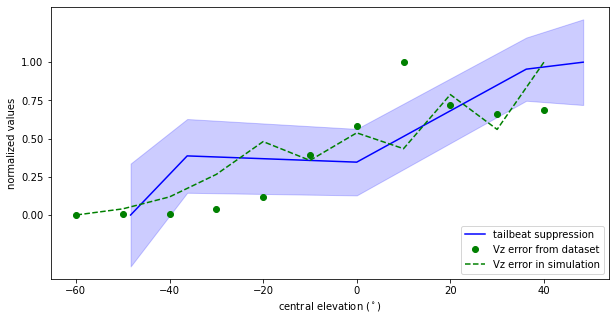

In [12]:
simulation_matchedpairs = True # show single elevation matched pair simulation
simulation_matchedpairslowres = False # use bimodal heat map matches
simulation_global = False # use global simulation

plt.figure(figsize=(15,10),facecolor='w')

####################
# behavior  - code from plot_tailbeats notebook
####################
    data = pandas.read_csv('../LarvalZebrafishBehavior/behavioral_data/DataFrame_tailbeats_forward.csv') # raw tail beat response data
    forward_masks = loadmat('../LarvalZebrafishBehavior/behavioral_data/Stimulus_masks_forward.mat')['data'][0][0] # masks indicating which LEDs are on for each stimulus
    LED_coords = forward_masks[0][0][0]
    LED_azimuths = LED_coords[0]
    LED_elevations = LED_coords[1]
    LED_number = LED_azimuths.shape[0]

    elevation_stimulus_ids = [14, 18, 16, 19, 15]
    single_trial_duration = 6 # s

    # Set up
    azimuth_ticks = [-180, -90, 0, 90, 180]
    azimuth_tick_lims = (np.min(azimuth_ticks), np.max(azimuth_ticks))
    elevation_ticks = [-90, -45, 0, 45, 90]
    elevation_tick_lims = (np.min(elevation_ticks), np.max(elevation_ticks))
    spherical_arena_coverage = 0.8558 #  fraction of full sphere covered by stimulation arena
    stimulus_number = 19 #  number of different stimuli used in experiments (each covering different areas of sphere)

    # Calculate normalized repeats for selected (pure elevation) stimuli
    grp_trials_norm = data[data.stimulus.isin([f's{stim_id:02d}' for stim_id in elevation_stimulus_ids])].groupby(['date', 'fish'])
    df_trials_norm = pandas.DataFrame()
    df_trials_norm['stimulus'] = grp_trials_norm.apply(lambda df: df.stimulus)
    df_trials_norm['repeat'] = grp_trials_norm.apply(lambda df: df.repeat)
    df_trials_norm['tailbeat_norm'] = grp_trials_norm.apply(lambda df: df.tail_beat / df.tail_beat.max())
    df_trials_norm = df_trials_norm.reset_index()

    # Calculate and add center azimuth for each stimulus
    df_trials_norm['center_elevation'] = np.nan
    for stim_id in elevation_stimulus_ids:
        mask = np.copy(forward_masks[stim_id][0][0][0]).astype('float')
        mask[mask==0] = np.nan
        selection = df_trials_norm.stimulus == f's{stim_id:02d}'
        df_trials_norm.loc[selection, 'center_elevation'] = np.nanmean(mask * LED_elevations)
        # Correct for stimulation area
        # df_trials_norm.loc[selection, 'tailbeat_norm'] *= spherical_arena_coverage * 4 * np.pi * LED_number / np.isfinite(mask).sum()  / single_trial_duration
        df_trials_norm.loc[selection, 'tailbeat_norm'] /= spherical_arena_coverage * 4 * np.pi * np.isfinite(mask).sum() * single_trial_duration / LED_number

    # Plot
    plt.figure(figsize=(10,5), facecolor='w')
    grp_fish = df_trials_norm.groupby(['date', 'fish'])

    # Mean and SD
    grp_by_elevation = df_trials_norm.groupby(['center_elevation'])
    df_elevations = pandas.DataFrame()
    df_elevations['tailbeat_mean'] = grp_by_elevation.tailbeat_norm.mean()
    df_elevations['tailbeat_stderr'] = grp_by_elevation.tailbeat_norm.std() / np.sqrt(len(grp_fish))

    # convert to suppression -- max response = 0 suppression, mun response = 1 suppression
    #tailbeat_max = np.nanmax(df_elevations.tailbeat_mean+df_elevations.tailbeat_stderr)
    #tailbeat_min = np.nanmin(df_elevations.tailbeat_mean-df_elevations.tailbeat_stderr)
    tailbeat_max = np.nanmax(df_elevations.tailbeat_mean)
    tailbeat_min = np.nanmin(df_elevations.tailbeat_mean)
    tailbeat_mean_1_0 = 1 - (df_elevations.tailbeat_mean-tailbeat_min)/(tailbeat_max-tailbeat_min)
    tailbeat_stderr_0_1 = df_elevations.tailbeat_stderr/(tailbeat_max-tailbeat_min)
    print(f'tailbeats scaled {tailbeat_max} to {tailbeat_min} norm. tailbeats/(sec * str)')


    plt.plot(df_elevations.index, tailbeat_mean_1_0,'b',label='tailbeat suppression')
    plt.fill_between(df_elevations.index,
                     tailbeat_mean_1_0 - tailbeat_stderr_0_1,
                     tailbeat_mean_1_0 + tailbeat_stderr_0_1,
                     color='b', alpha=.2)
    plt.xlabel('center elevation ($^\circ$)')
    plt.ylabel('swim suppression',c='b')

####################
# real data - single elevations
####################
data = np.load('./estimates/3DOFerrs.npz') # already in mm/s
errs = data['errs_singleelev']
realerrs = np.array([np.nanmedian(errs[:,:,e,:,1]) for e in range(len(data['elevs']))])
err_min = np.nanmin(realerrs)
err_max = np.nanmax(realerrs)
dataelevs = data['elevs']
plt.plot(dataelevs,(realerrs-err_min)/(err_max-err_min),'og',label='Vz error from dataset')

print(f'real data Vz errors scaled {err_min:.03f} to {err_max:.03f} mm/s')

####################
# simulation - single elevations
####################
sests = np.load('./estimates/simests.npz')['sests_3DOF']
speeds = np.array([[0,0,20],[0,0,50],
      [0,40,0],[40,0,0],[40/np.sqrt(2),40/np.sqrt(2),0],
      [0,60,0],[60,0,0],[60/np.sqrt(2),60/np.sqrt(2),0],
      [0,40,45],[0,60,50],[0,40,15],[0,60,20]])
serrs = np.nan*np.ones_like(sests)
for s in range(len(speeds)):
    gt = speeds[s]
    serrs[:,s,:,:,:3] = np.abs(sests[:,s,:,:,:] - gt)
Vzmederr = [np.nanmedian(serrs[:,:,e,:,1]) for e in range(len(dataelevs))]
sim_min = np.nanmin(Vzmederr)
sim_max = np.nanmax(Vzmederr)
plt.plot(dataelevs,(Vzmederr-sim_min)/(sim_max-sim_min),'--g',label='Vz error in simulation')
print(f'local simulation Vz errors scaled {sim_min:.03f} to {sim_max:.03f} mm/s')

plt.legend(loc='lower right')
plt.yticks([0,.25,.5,.75,1])
plt.ylabel('normalized values',c='k')
plt.xlabel('central elevation ($^\circ$)')

plt.savefig(f'graphicalabstractplot.eps', format='eps',dpi=300)